In [6]:
from time import time

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]


def size_mb(docs):
    return sum(len(s.encode("utf-8")) for s in docs) / 1e6


def load_dataset(verbose=False, remove=()):
    """Load and vectorize the 20 newsgroups dataset."""

    data_train = fetch_20newsgroups(
        subset="train",
        categories=categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )

    data_test = fetch_20newsgroups(
        subset="test",
        categories=categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )

    # order of labels in `target_names` can be different from `categories`
    target_names = data_train.target_names

    # split target in a training set and a test set
    y_train, y_test = data_train.target, data_test.target

    # Extracting features from the training data using a sparse vectorizer
    t0 = time()
    vectorizer = TfidfVectorizer(
        sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english"
    )
    X_train = vectorizer.fit_transform(data_train.data)
    duration_train = time() - t0

    # Extracting features from the test data using the same vectorizer
    t0 = time()
    X_test = vectorizer.transform(data_test.data)
    duration_test = time() - t0

    feature_names = vectorizer.get_feature_names_out()

    if verbose:
        # compute size of loaded data
        data_train_size_mb = size_mb(data_train.data)
        data_test_size_mb = size_mb(data_test.data)

        print(
            f"{len(data_train.data)} documents - "
            f"{data_train_size_mb:.2f}MB (training set)"
        )
        print(f"{len(data_test.data)} documents - {data_test_size_mb:.2f}MB (test set)")
        print(f"{len(target_names)} categories")
        print(
            f"vectorize training done in {duration_train:.3f}s "
            f"at {data_train_size_mb / duration_train:.3f}MB/s"
        )
        print(f"n_samples: {X_train.shape[0]}, n_features: {X_train.shape[1]}")
        print(
            f"vectorize testing done in {duration_test:.3f}s "
            f"at {data_test_size_mb / duration_test:.3f}MB/s"
        )
        print(f"n_samples: {X_test.shape[0]}, n_features: {X_test.shape[1]}")

    return X_train, X_test, y_train, y_test, feature_names, target_names

In [8]:
X_train, X_test, y_train, y_test, feature_names, target_names = load_dataset(
    verbose=True
)

2034 documents - 3.98MB (training set)
1353 documents - 2.87MB (test set)
4 categories
vectorize training done in 0.718s at 5.546MB/s
n_samples: 2034, n_features: 7831
vectorize testing done in 0.511s at 5.607MB/s
n_samples: 1353, n_features: 7831


In [12]:
X_train.shape

(2034, 7831)

In [13]:
X_test.shape

(1353, 7831)

In [14]:
feature_names

array(['00', '000', '0005', ..., 'zoo', 'zoology', 'zyeh'], dtype=object)

In [15]:
target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

In [16]:
from sklearn.linear_model import RidgeClassifier

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [17]:
pred

array([2, 1, 1, ..., 3, 1, 1], dtype=int64)

In [18]:
clf

RidgeClassifier(solver='sparse_cg', tol=0.01)

[[258   7  12  42]
 [  2 380   4   3]
 [  1  22 371   0]
 [ 37   9   6 199]]


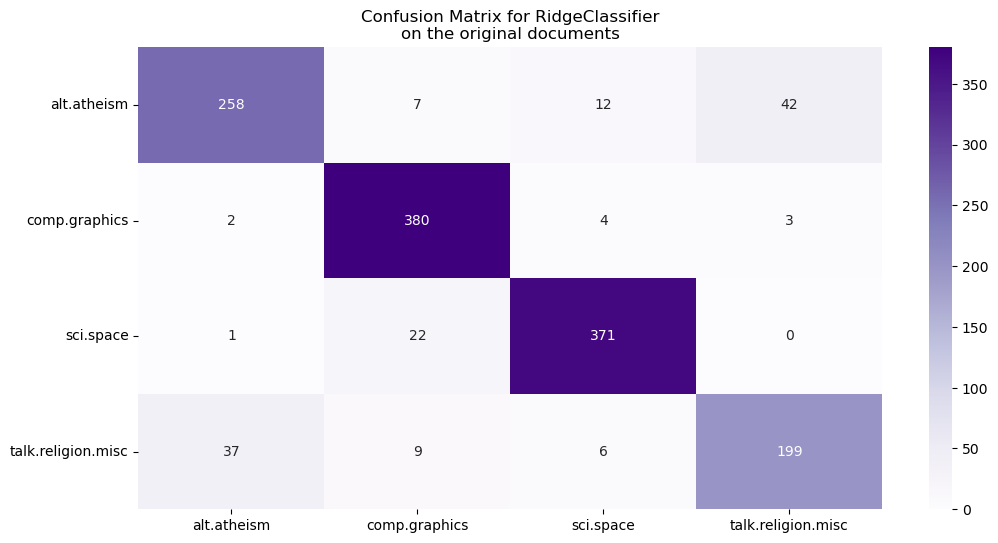

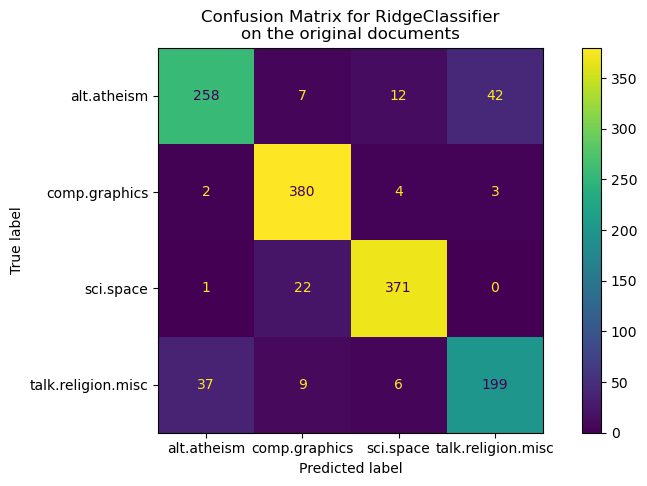

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
#METRICAS PARA MEDIR EXACTITUD - PRECISION ALGORITMOS
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn import metrics




#graficos scatter
plt.figure(figsize=(12,6))


conf_matrix = metrics.confusion_matrix(y_test, pred)
print(conf_matrix)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', 
           xticklabels=target_names, yticklabels=target_names
           # xticklabels=['No default', 'Default'], 
           # yticklabels=['No default', 'Default']
           )

plt.title(f"Confusion Matrix for {clf.__class__.__name__}\non the original documents")
# Obtener el objeto Axes
ax = plt.gca()

# Establecer las etiquetas de las marcas en los ejes x e y en posición horizontal
ax.set_xticklabels(target_names, rotation=0)
ax.set_yticklabels(target_names, rotation=0)






fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non the original documents"
)

top 5 keywords per class:
  alt.atheism comp.graphics sci.space talk.religion.misc
0       keith      graphics     space          christian
1         god    university      nasa                com
2    atheists        thanks     orbit                god
3      people          does      moon           morality
4     caltech         image    access             people


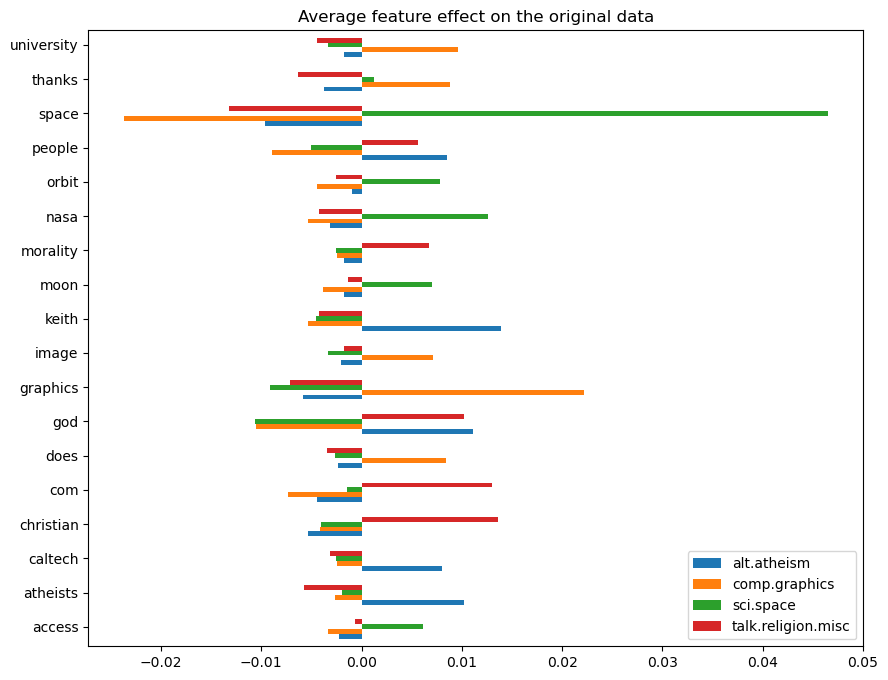

In [38]:
import numpy as np
import pandas as pd


def plot_feature_effects():
    # learned coefficients weighted by frequency of appearance
    average_feature_effects = clf.coef_ * np.asarray(X_train.mean(axis=0)).ravel()

    for i, label in enumerate(target_names):
        top5 = np.argsort(average_feature_effects[i])[-5:][::-1]
        if i == 0:
            top = pd.DataFrame(feature_names[top5], columns=[label])
            top_indices = top5
        else:
            top[label] = feature_names[top5]
            top_indices = np.concatenate((top_indices, top5), axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = feature_names[top_indices]

    # plot feature effects
    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(10, 8))
    for i, label in enumerate(target_names):
        ax.barh(
            y_locs + (i - 2) * bar_size,
            average_feature_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")

    print("top 5 keywords per class:")
    print(top)

    return ax


_ = plot_feature_effects().set_title("Average feature effect on the original data")

In [39]:
data_train = fetch_20newsgroups(
    subset="train", categories=categories, shuffle=True, random_state=42
)

for doc in data_train.data:
    if "caltech" in doc:
        print(doc)
        break

From: livesey@solntze.wpd.sgi.com (Jon Livesey)
Subject: Re: Morality? (was Re: <Political Atheists?)
Organization: sgi
Lines: 93
Distribution: world
NNTP-Posting-Host: solntze.wpd.sgi.com

In article <1qlettINN8oi@gap.caltech.edu>, keith@cco.caltech.edu (Keith Allan Schneider) writes:
|> livesey@solntze.wpd.sgi.com (Jon Livesey) writes:
|> 
|> >>>Explain to me
|> >>>how instinctive acts can be moral acts, and I am happy to listen.
|> >>For example, if it were instinctive not to murder...
|> >
|> >Then not murdering would have no moral significance, since there
|> >would be nothing voluntary about it.
|> 
|> See, there you go again, saying that a moral act is only significant
|> if it is "voluntary."  Why do you think this?

If you force me to do something, am I morally responsible for it?

|> 
|> And anyway, humans have the ability to disregard some of their instincts.

Well, make up your mind.    Is it to be "instinctive not to murder"
or not?

|> 
|> >>So, only intelligent beings ca

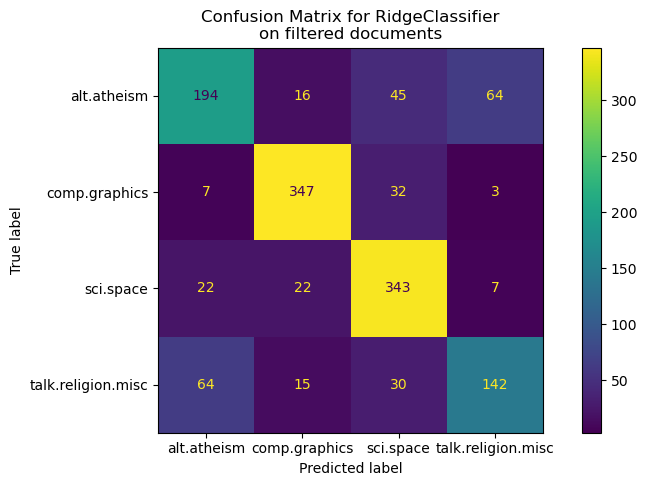

In [40]:
(
    X_train,
    X_test,
    y_train,
    y_test,
    feature_names,
    target_names,
) = load_dataset(remove=("headers", "footers", "quotes"))

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non filtered documents"
)

top 5 keywords per class:
  alt.atheism comp.graphics sci.space talk.religion.misc
0         don      graphics     space                god
1      people          file      like          christian
2         say        thanks      nasa              jesus
3    religion         image     orbit         christians
4        post          does    launch              wrong


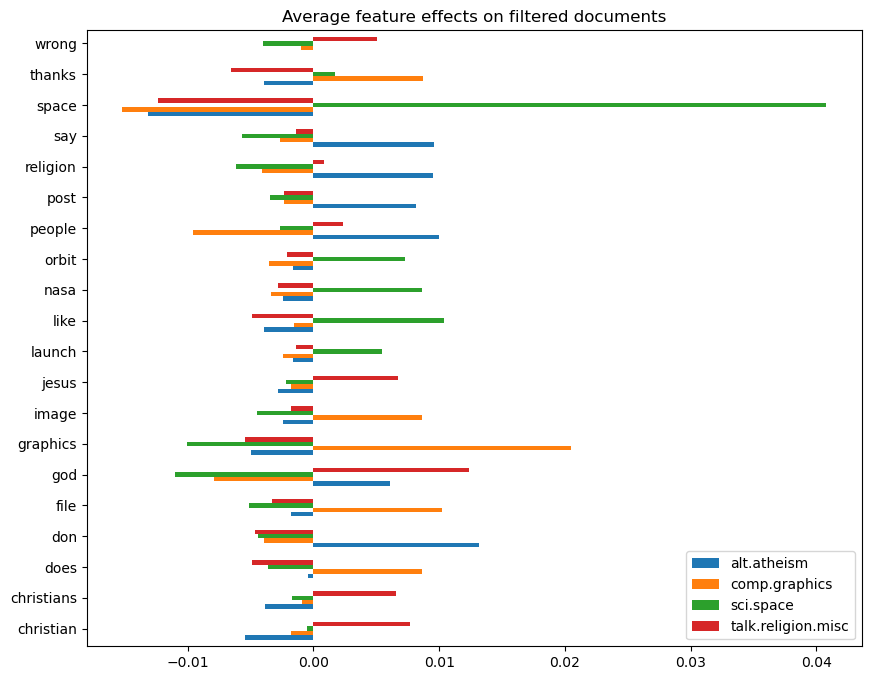

In [41]:
_ = plot_feature_effects().set_title("Average feature effects on filtered documents")

In [42]:
from sklearn import metrics
from sklearn.utils.extmath import density


def benchmark(clf, custom_name=False):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(f"train time: {train_time:.3}s")

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print(f"test time:  {test_time:.3}s")

    score = metrics.accuracy_score(y_test, pred)
    print(f"accuracy:   {score:.3}")

    if hasattr(clf, "coef_"):
        print(f"dimensionality: {clf.coef_.shape[1]}")
        print(f"density: {density(clf.coef_)}")
        print()

    print()
    if custom_name:
        clf_descr = str(custom_name)
    else:
        clf_descr = clf.__class__.__name__
    return clf_descr, score, train_time, test_time

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import LinearSVC

results = []
for clf, name in (
    (LogisticRegression(C=5, max_iter=1000), "Logistic Regression"),
    (RidgeClassifier(alpha=1.0, solver="sparse_cg"), "Ridge Classifier"),
    (KNeighborsClassifier(n_neighbors=100), "kNN"),
    (RandomForestClassifier(), "Random Forest"),
    # L2 penalty Linear SVC
    (LinearSVC(C=0.1, dual=False, max_iter=1000), "Linear SVC"),
    # L2 penalty Linear SGD
    (
        SGDClassifier(
            loss="log_loss", alpha=1e-4, n_iter_no_change=3, early_stopping=True
        ),
        "log-loss SGD",
    ),
    # NearestCentroid (aka Rocchio classifier)
    (NearestCentroid(), "NearestCentroid"),
    # Sparse naive Bayes classifier
    (ComplementNB(alpha=0.1), "Complement naive Bayes"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, name))

Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression(C=5, max_iter=1000)
train time: 0.515s
test time:  0.0s
accuracy:   0.773
dimensionality: 5316
density: 1.0


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sparse_cg')
train time: 0.0474s
test time:  0.00144s
accuracy:   0.76
dimensionality: 5316
density: 1.0


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=100)
train time: 0.00129s
test time:  1.64s
accuracy:   0.752

Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 5.69s
test time:  0.063s
accuracy:   0.709

Linear SVC
________________________________________________________________________________
Training: 
LinearSVC(C=0.1, dual=False)
train tim

For classifier Logistic Regression: Score = 0.7730968218773097, Training Time = 0.487215518951416


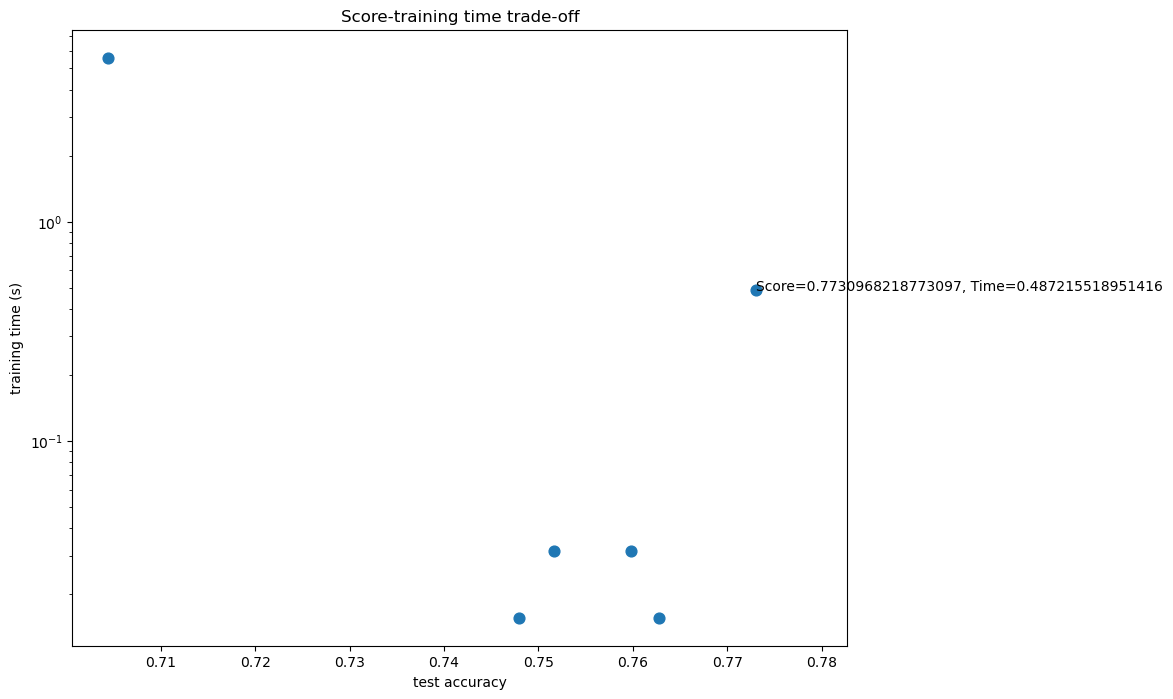

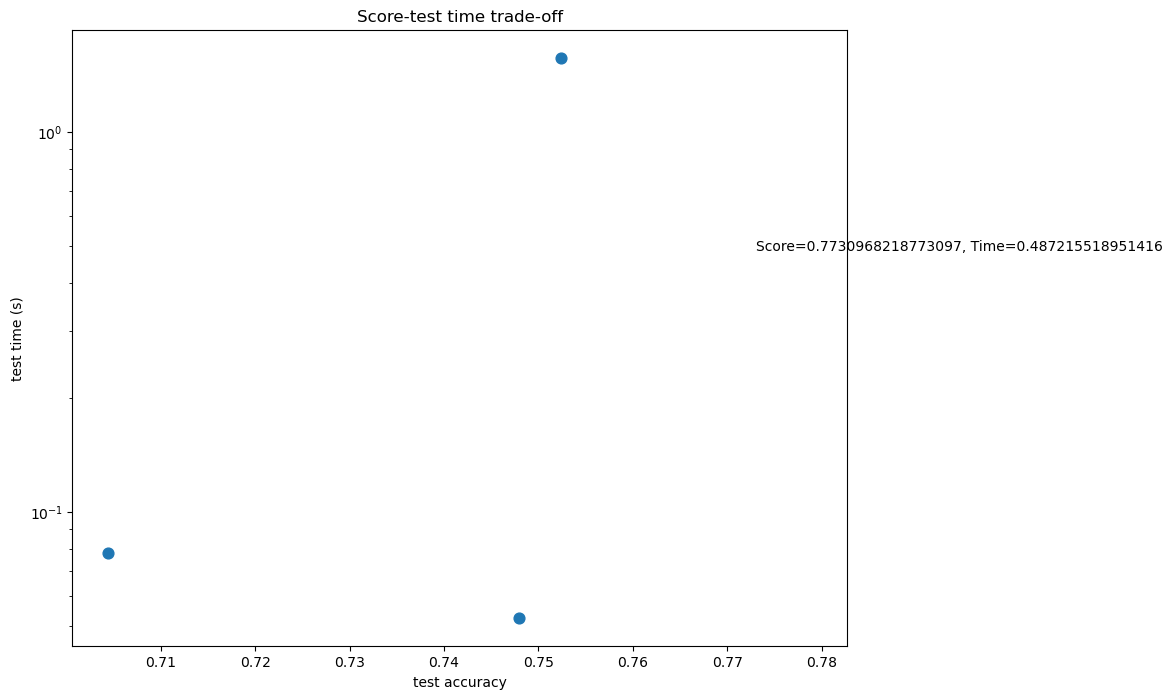

In [88]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time)
test_time = np.array(test_time)

fig, ax1 = plt.subplots(figsize=(10, 8))
#ax1.scatter(score, training_time, s=60)
ax1.scatter(results_df['score'],results_df['training_time'],s=60)
ax1.set(
    title="Score-training time trade-off",
    yscale="log",
    xlabel="test accuracy",
    ylabel="training time (s)",
)


fig, ax2 = plt.subplots(figsize=(10, 8))
#ax2.scatter(score, test_time, s=60)
ax2.scatter(results_df['score'],results_df['test_time'],s=60)
ax2.set(
    title="Score-test time trade-off",
    yscale="log",
    xlabel="test accuracy",
    ylabel="test time (s)",
)

#for i, txt in enumerate(clf_names):
#   ax1.annotate(txt, (results_df['score'],results_df['training_time']))
#   ax2.annotate(txt, (results_df['score'],results_df['test_time']))




In [83]:
results

[['Logistic Regression',
  'Ridge Classifier',
  'kNN',
  'Random Forest',
  'Linear SVC',
  'log-loss SGD',
  'NearestCentroid',
  'Complement naive Bayes'],
 [0.7730968218773097,
  0.7597930524759793,
  0.7524020694752402,
  0.6999260901699926,
  0.7516629711751663,
  0.762010347376201,
  0.7479674796747967,
  0.779009608277901],
 [0.5099303722381592,
  0.03717303276062012,
  0.009732961654663086,
  5.5650599002838135,
  0.03702092170715332,
  0.02566671371459961,
  0.0,
  0.014082670211791992],
 [0.0,
  0.0,
  1.528186321258545,
  0.053719520568847656,
  0.0,
  0.0,
  0.050489187240600586,
  0.0]]

In [84]:
results_df = pd.DataFrame(results, columns=['clf_names', 'score', 'training_time', 'test_time'])

ValueError: 4 columns passed, passed data had 8 columns

In [85]:
results_df 

,clf_names,score,training_time,test_time
0,Logistic Regression,0.773097,0.487216,0.000000
1,Ridge Classifier,0.759793,0.031471,0.000000
2,kNN,0.752402,0.000000,1.568165
3,Random Forest,0.704361,5.595208,0.078127
4,Linear SVC,0.751663,0.031436,0.000000
5,log-loss SGD,0.762749,0.015649,0.000000
6,NearestCentroid,0.747967,0.015620,0.052724
7,Complement naive Bayes,0.779010,0.000000,0.000000


In [67]:
results

[('Logistic Regression', 0.7730968218773097, 0.487215518951416, 0.0),
 ('Ridge Classifier', 0.7597930524759793, 0.03147077560424805, 0.0),
 ('kNN', 0.7524020694752402, 0.0, 1.5681653022766113),
 ('Random Forest', 0.704360679970436, 5.595207691192627, 0.07812714576721191),
 ('Linear SVC', 0.7516629711751663, 0.03143644332885742, 0.0),
 ('log-loss SGD', 0.7627494456762749, 0.015649080276489258, 0.0),
 ('NearestCentroid',
  0.7479674796747967,
  0.015619516372680664,
  0.05272364616394043),
 ('Complement naive Bayes', 0.779009608277901, 0.0, 0.0)]